In [1]:
import numpy as np
import scipy as sp
%load_ext memory_profiler

In [2]:
# Covariogram parameters 
L = (12.1, 8.5) 
theta = 45 * np.pi/180
sigma_prior2 = 1.0
nx = 5
ny = 3
nc = nx*ny
inp = (nx, ny, L, theta, sigma_prior2)

In [3]:
def CalcHL(x0, x1, L, theta):
    cosT = np.cos(theta)
    sinT = np.sin(theta)
    dx = x1[0] - x0[0]
    dy = x1[1] - x0[1]

    dxRot = np.array([[cosT, -sinT], [sinT, cosT]]) @ np.array([[dx], [dy]])
    dxFlat = dxRot.flatten()

    return np.sqrt((dxFlat[0]/L[0])**2 + (dxFlat[1]/L[1])**2)

# Calc covariance between two gridblocks
def SphereFunction(x0, x1, L, theta, sigmaPr2):
    hl = CalcHL(x0, x1, L, theta)

    if (hl > 1):
        return 0
    
    return sigmaPr2 * (1.0 - 3.0/2.0*hl + (hl**3)/2)

# convert index numeration to I J index
def IndexToIJ(index, ni, nj):
    return ((index % ni) + 1, (index // ni) + 1)

# Convert i J numeration to index
def IJToIndex(i,j,ni,nj):
    return (i-1) + (j-1)*ni

def gabriel(Ni, Nj, L, theta, sigmaPr2):
    Nmatrix = Ni * Nj
    Cm = np.empty([Nmatrix, Nmatrix])
    for index0 in range(Nmatrix):
        I0 = IndexToIJ(index0,Ni,Nj)
        for index1 in range(Nmatrix):
            I1 = IndexToIJ(index1,Ni,Nj)
            Cm[index0, index1] = SphereFunction(I0, I1, L, theta, sigmaPr2)
    return Cm

In [4]:
def ilshat(Ni, Nj, L, theta, sigmaPr2):
    cosT = np.cos(theta)
    sinT = np.sin(theta)

    Nmatrix = Ni * Nj
    index = np.arange(Nmatrix)  # 1D-index
    I = index % Ni + 1  # 2D-indices
    J = index // Ni + 1
    I0, I1 = np.meshgrid(I, I)
    J0, J1 = np.meshgrid(J, J)
    dx = I1 - I0
    dy = J1 - J0
    # rotate
    dxRot = cosT * dx - sinT * dy
    dyRot = sinT * dx + cosT * dy
    # norm
    hl = np.sqrt((dxRot/L[0])**2 + (dyRot/L[1])**2)

    Cm = sigmaPr2 * (1.0 - 3.0 / 2.0 * hl + (hl ** 3) / 2)
    Cm[hl > 1] = 0
    return Cm

In [5]:
def full_dieter(nx, ny, length, theta, sigma_pr2):
    nc = nx*ny
    cost = np.cos(theta)
    sint = np.sin(theta)

    # Fill the first row nx * nc
    tmp = np.zeros([nx, nc])
    for i in range(nx):
        x0 = (i % nx) + 1
        x1 = (i // nx) + 1
        for j in range(i+1, nc):
            y0 = (j % nx) + 1
            y1 = (j // nx) + 1
            d0 = y0 - x0
            d1 = y1 - x1
            rot0 = cost*d0 - sint*d1
            rot1 = sint*d0 + cost*d1

            hl = np.sqrt((rot0/length[0])**2 + (rot1/length[1])**2)

            # Calculate value.
            if hl <= 1:
                tmp[i, j] = sigma_pr2 * (1 - 3/2*hl + (hl**3)/2)

    # Fill the upper triangle by copying the first row
    cov = np.zeros([nc, nc])
    for j in range(ny):
        cov[nx*j:nx*(j+1), nx*j:] = tmp[:, :nc-nx*j]
    # Fill the lower triangle with the transpose
    cov += cov.T
    # Add the diagonal
    cov += np.diag(np.ones(nc))

    return cov

In [13]:
def sparse_dieter(nx, ny, length, theta, sigma_pr2):
    nc = nx*ny
    cost = np.cos(theta)
    sint = np.sin(theta)

    # TODO
    # First, do diagnoal
    # Then, loop over i in range(1, nc):
    # compute the diagonal values of first nx entries
    # if any non-zero, repeat-ny-times and add to sparse on both sides
    
    # Fill the first row nx * nc
    tmp = np.zeros([nx, nc])
    for i in range(nx):
        x0 = (i % nx) + 1
        x1 = (i // nx) + 1
        for j in range(i+1, nc):
            y0 = (j % nx) + 1
            y1 = (j // nx) + 1
            d0 = y0 - x0
            d1 = y1 - x1
            rot0 = cost*d0 - sint*d1
            rot1 = sint*d0 + cost*d1

            hl = np.sqrt((rot0/length[0])**2 + (rot1/length[1])**2)

            # Calculate value.
            if hl <= 1:
                tmp[i, j] = sigma_pr2 * (1 - 3/2*hl + (hl**3)/2)

    # Fill the upper triangle by copying the first row
    cov = np.zeros([nc, nc])
    for j in range(ny):
        cov[nx*j:nx*(j+1), nx*j:] = tmp[:, :nc-nx*j]
    # Fill the lower triangle with the transpose
    cov += cov.T
    # Add the diagonal
    cov += np.diag(np.ones(nc))

    return cov

Identical: True


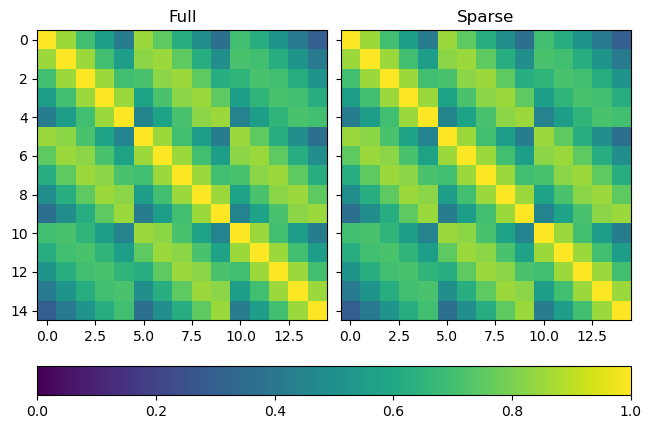

In [20]:
fdi = full_dieter(*inp)
sdi = sparse_dieter(*inp)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)
axs[0].set_title('Full')
axs[1].set_title('Sparse')
im = axs[0].imshow(fdi, aspect='equal', vmin=0, vmax=1)
axs[1].imshow(sdi, aspect='equal', vmin=0, vmax=1)
fig.colorbar(im, ax=axs, orientation='horizontal')
print(f"Identical: {np.allclose(fdi, sdi)}")

In [14]:
gab = gabriel(*inp)
ils = ilshat(*inp)
fdi = full_dieter(*inp)
sdi = sparse_dieter(*inp)

np.allclose(gab, ils), np.allclose(gab, fdi), np.allclose(gab, sdi)

(True, True, True)

In [15]:
%timeit gabriel(*inp)
%timeit ilshat(*inp)
%timeit full_dieter(*inp)
%timeit sparse_dieter(*inp)

2.61 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
103 µs ± 7.13 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
153 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
180 µs ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%memit gabriel(*inp)
%memit ilshat(*inp)
%memit full_dieter(*inp)
%memit sparse_dieter(*inp)

peak memory: 130.59 MiB, increment: 0.00 MiB
peak memory: 130.59 MiB, increment: 0.00 MiB
peak memory: 130.59 MiB, increment: 0.00 MiB
peak memory: 130.59 MiB, increment: 0.00 MiB
